The goal of this notebook is to attempt to predict the causes of wildfires given data on its location, its size, and the discovery date. I will use the previous notebook on the exploratory analysis to select the variables that will be used in different machine learing algorithms.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


# Connect to the database and import the table 'Fires'
import os
import sqlite3

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


conn = sqlite3.connect('/kaggle/input/us-wildfire-records-6th-edition/data.sqlite') 
df = pd.read_sql_query('SELECT * FROM Fires;', con=conn)

# Close connection
conn.close()

# Select only columns of interest
col_of_interest = ['OBJECTID', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY', 'NWCG_GENERAL_CAUSE', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE' , 'LONGITUDE' , 'STATE']
df = df[col_of_interest].set_index('OBJECTID', verify_integrity = True)

# Rename the columns and the index
df = df.rename(columns = {'FIRE_YEAR':'fire_year',
                         'DISCOVERY_DATE':'disc_date',
                         'DISCOVERY_DOY':'disc_doy',
                         'NWCG_GENERAL_CAUSE':'cause',
                         'FIRE_SIZE' : 'fire_size',
                         'FIRE_SIZE_CLASS' : 'fire_class',
                         'LATITUDE':'latitude',
                         'LONGITUDE':'longitude',
                         'STATE':'state'}).rename_axis('id')

# Convert the columns 'disc_date' in datetime format and add a colmun with the month
df['disc_date'] = pd.to_datetime(pd.to_datetime(df['disc_date'], format = '%m/%d/%Y').dt.strftime('%Y-%m-%d'))
df.insert(3, 'disc_month', df['disc_date'].dt.month)
df.insert(4, 'disc_day', df['disc_date'].dt.day_name())

# Define a new column 'origin'
map_cause = {'Power generation/transmission/distribution':'Accidental',
            'Natural':'Natural',
            'Debris and open burning':'Accidental',
            'Missing data/not specified/undetermined':'Undefined',
            'Recreation and ceremony':'Accidental',
            'Equipment and vehicle use':'Accidental',
            'Arson/incendiarism':'Criminal',
            'Fireworks':'Accidental',
            'Other causes':'Accidental',
            'Railroad operations and maintenance':'Accidental',
            'Smoking':'Accidental',
            'Misuse of fire by a minor':'Accidental',
            'Firearms and explosives use':'Accidental'}

df['origin'] = df['cause'].map(map_cause)

# For the analysis, we focus on the contiguous USA and define four main geographic area
df = df.loc[(df['latitude']>=25) & (df['latitude']<=50)]

df.head()

/kaggle/input/us-wildfire-records-6th-edition/_variable_descriptions.csv
/kaggle/input/us-wildfire-records-6th-edition/data.sqlite
/kaggle/input/us-wildfire-records-6th-edition/data.csv


,fire_year,disc_date,disc_doy,disc_month,disc_day,cause,fire_size,fire_class,latitude,longitude,state,origin
id,,,,,,,,,,,,
1,2005,2005-02-02,33,2,Wednesday,Power generation/transmission/distribution,0.10,A,40.036944,-121.005833,CA,Accidental
2,2004,2004-05-12,133,5,Wednesday,Natural,0.25,A,38.933056,-120.404444,CA,Natural
3,2004,2004-05-31,152,5,Monday,Debris and open burning,0.10,A,38.984167,-120.735556,CA,Accidental
4,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.913333,CA,Natural
5,2004,2004-06-28,180,6,Monday,Natural,0.10,A,38.559167,-119.933056,CA,Natural


# 1. Selection of variables and feature engineering

We know that the cause of wildfire varies largely across states. For the spatial dimension, I will use latitude and longitude coordinates because they provide a finest resolution than states.

For the temporal dimension, I will use day of week, the month and, of course, the year.

Finally, I have to decide either 'fire_size' or 'fire_class' to be used. 

<Axes: ylabel='Frequency'>

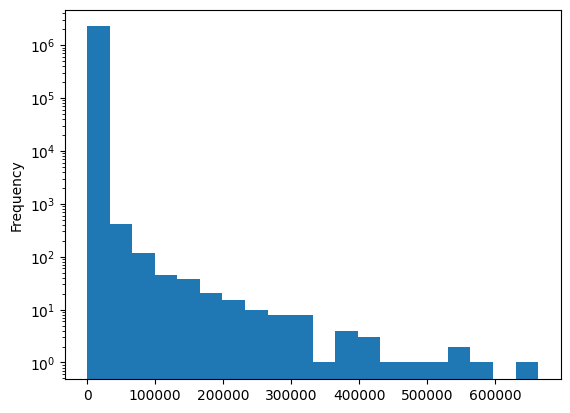

In [7]:
df['fire_size'].plot(kind = 'hist', bins = 20, log = True)

The distribution of 'fire_size' is unbalanced toward small values. As this could be problematic for the machine learing, I will use 'fire_class' instead.

In [8]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler

# target versus features
labels = df['cause']
features = df.drop(columns = ['disc_date', 'disc_doy', 'cause', 'fire_size', 'state', 'origin'])

In [10]:
labels

id
1          Power generation/transmission/distribution
2                                             Natural
3                             Debris and open burning
4                                             Natural
5                                             Natural
                              ...                    
2303562                                       Natural
2303563       Missing data/not specified/undetermined
2303564                                       Natural
2303565                                       Natural
2303566       Missing data/not specified/undetermined
Name: cause, Length: 2255905, dtype: object